In [0]:
import torch
import torchvision
import os
import shutil
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms, models
from tqdm import tqdm
from google.colab import drive

#drive.mount('/content/drive', force_remount=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!nvidia-smi

Tue Sep 17 11:06:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    927MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# unzip datasets and move to the notebook
#!unzip '../content/drive/My Drive/datasets/plates.zip'
#print(os.listdir(data_root))

In [0]:
# freeze random, set cuda to deterministic mode
def set_random_seed(val):
  random.seed(val)
  np.random.seed(val)
  torch.manual_seed(val)
  torch.cuda.manual_seed(val)
  torch.backends.cudnn.deterministic = True

set_random_seed(1)

In [0]:
data_root = '../content/plates/'
!ls plates/train

cleaned  dirty


In [0]:
train_dir = 'plates/train'

train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(1.0, 0.3, 0.3, 0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

info_data = 'train data [batches: {0} , files: {1}]'.format(len(train_dataloader),len(train_dataset))
print(info_data)

train data [batches: 4 , files: 40]


In [0]:
# show input batch from dataloader
class_names = ['cleaned', 'dirty']
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225]) 

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)
    
#X_batch, y_batch = next(iter(train_dataloader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=class_names[y_item])    

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    model.train() # set model to train mode
    
    train_history_loss = []
    train_history_acc = []
    
    for epoch in range(num_epochs):
      
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        
        # after each epoch reduce step of gradient descent
        scheduler.step()
        
        running_loss = 0.
        running_acc = 0.
        
        # interate over data
        for inputs, labels in tqdm(train_dataloader):
          
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          optimizer.zero_grad()
          
          with torch.set_grad_enabled(True):
              predicts = model(inputs)
              loss_value = loss(predicts, labels)
              predicts_class = predicts.argmax(dim=1)
              loss_value.backward()
              optimizer.step()
              
          running_loss += loss_value.item()
          running_acc += (predicts_class == labels.data).float().mean()
            
        epoch_loss = running_loss / len(train_dataloader)   
        epoch_acc = running_acc / len(train_dataloader)
    
        train_history_loss.append(epoch_loss)
        train_history_acc.append(epoch_acc)
    
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc), flush=True)
    
    del model
    return train_history_loss, train_history_acc

In [0]:
def prepare_model(model):
  # disable gradient for all convolution layers
  for param in model.parameters():
    param.requires_grad = False
  # replace last layer
  #model.fc = torch.nn.Linear(model.fc.in_features, 2)
  model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.15),
    torch.nn.Linear(model.fc.in_features, 2)
    )
  model = model.to(device)
  return model

In [0]:
accuracies = {}
losses = {}

loss = torch.nn.CrossEntropyLoss()

# adam 
model_1 = prepare_model(models.resnet101(pretrained=True))
model_1.name = 'Resnet50 № 01'
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1.0e-3, amsgrad=True)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.1)
losses[model_1.name], accuracies[model_1.name]  = train_model(model_1, loss, optimizer_1, scheduler_1, num_epochs=40);

Epoch 0/39:



100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Loss: 0.6458 Acc: 0.5750
Epoch 1/39:



100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Loss: 0.7438 Acc: 0.5000
Epoch 2/39:



100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Loss: 0.6143 Acc: 0.6500
Epoch 3/39:



100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Loss: 0.5950 Acc: 0.7000
Epoch 4/39:



100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


Loss: 0.5729 Acc: 0.7250
Epoch 5/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.4868 Acc: 0.7750
Epoch 6/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.5282 Acc: 0.7500
Epoch 7/39:



100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


Loss: 0.4449 Acc: 0.8500
Epoch 8/39:



100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Loss: 0.4343 Acc: 0.9000
Epoch 9/39:



100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Loss: 0.4610 Acc: 0.7250
Epoch 10/39:



100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Loss: 0.4019 Acc: 0.8750
Epoch 11/39:



100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Loss: 0.4715 Acc: 0.7750
Epoch 12/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.4411 Acc: 0.8000
Epoch 13/39:



100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Loss: 0.3731 Acc: 0.8750
Epoch 14/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.4225 Acc: 0.8500
Epoch 15/39:



100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Loss: 0.3450 Acc: 0.8750
Epoch 16/39:



100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Loss: 0.4690 Acc: 0.7500
Epoch 17/39:



100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Loss: 0.3545 Acc: 0.9000
Epoch 18/39:



100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Loss: 0.4536 Acc: 0.8250
Epoch 19/39:



100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Loss: 0.3767 Acc: 0.9000
Epoch 20/39:



100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Loss: 0.4051 Acc: 0.8500
Epoch 21/39:



100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Loss: 0.3928 Acc: 0.8500
Epoch 22/39:



100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Loss: 0.3677 Acc: 0.8250
Epoch 23/39:



100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Loss: 0.3523 Acc: 0.8750
Epoch 24/39:



100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Loss: 0.3674 Acc: 0.9250
Epoch 25/39:



100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Loss: 0.4009 Acc: 0.8250
Epoch 26/39:



100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Loss: 0.4295 Acc: 0.8750
Epoch 27/39:



100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Loss: 0.3733 Acc: 0.9000
Epoch 28/39:



100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


Loss: 0.3512 Acc: 0.9250
Epoch 29/39:



100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Loss: 0.3856 Acc: 0.8750
Epoch 30/39:



100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


Loss: 0.4461 Acc: 0.7750
Epoch 31/39:



100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Loss: 0.3753 Acc: 0.8500
Epoch 32/39:



100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Loss: 0.4145 Acc: 0.8750
Epoch 33/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.3291 Acc: 0.9500
Epoch 34/39:



100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Loss: 0.3458 Acc: 0.9500
Epoch 35/39:



100%|██████████| 4/4 [00:01<00:00,  2.50it/s]


Loss: 0.4402 Acc: 0.7250
Epoch 36/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.4463 Acc: 0.8500
Epoch 37/39:



100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Loss: 0.3543 Acc: 0.9000
Epoch 38/39:



100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


Loss: 0.3779 Acc: 0.8250
Epoch 39/39:



100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Loss: 0.4969 Acc: 0.7500


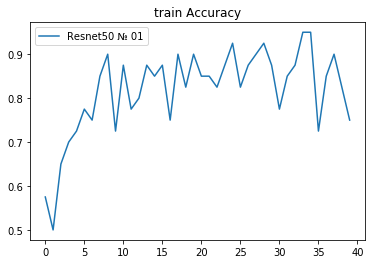

In [0]:
for net_name in ['Resnet50 № 01']:
  plt.plot(accuracies[net_name], label=net_name)
plt.legend()
plt.title('train Accuracy');

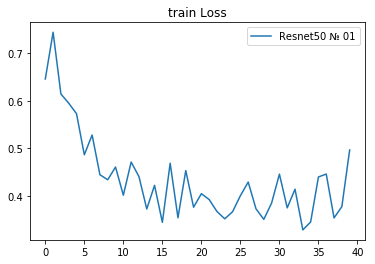

In [0]:
for net_name in ['Resnet50 № 01']:
  plt.plot(losses[net_name], label=net_name)
plt.legend()
plt.title('train Loss');

In [0]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [0]:
model_1.eval()

test_predictions = []
test_img_paths = []

test_acc = 0.

for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model_1(inputs)
        predicts_class = preds.argmax(dim=1)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    test_acc += (predicts_class == labels.data).float().mean()

test_acc = test_acc / len(test_dataloader)
test_predictions = np.concatenate(test_predictions)

print('Test accuracy: {0}'.format(test_acc))


100%|██████████| 75/75 [00:13<00:00,  5.68it/s]

Test accuracy: 0.27000007033348083


In [0]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [0]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [0]:
submission_df.to_csv('submission.csv')

In [0]:
#!rm -rf test submission.csv